## Liquidity Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

sns.set_theme(style="whitegrid")

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")
df_lp_holders_bad = pd.read_csv("../csv_outputs/bad_tokens/master_lp_holders.csv")
df_lp_holders_good = pd.read_csv("../csv_outputs/good_tokens/master_lp_holders.csv")


In [ ]:
# Convert 'percent' from decimal (e.g. 0.009) to percentage (e.g. 0.9%)
df_lp_holders['percent'] = df_lp_holders['percent'] * 100

# Round the 'percent' column to 4 decimal places for clean presentation and calculations
df_lp_holders['percent'] = df_lp_holders['percent'].round(4)

# Now group by token_address
grouped = df_lp_holders.groupby("token_address")

# Aggregate summary stats for each token
summary = grouped.agg({
    "balance": "sum",         # total LP balance
    "percent": "sum",         # total percentage (should now be close to 100%)
    "address": "count",       # number of LP holders
    "is_locked": "sum"        # number of locked holders (True counts as 1)
}).rename(columns={
    "balance": "total_balance",
    "percent": "total_percent",
    "address": "num_holders",
    "is_locked": "num_locked"
})

# Reset index so token_address is a column again
summary = summary.reset_index()

# View result
summary.head()


,token_address,total_balance,total_percent,num_holders,num_locked
0,0x002127Ec60f4b0F75F7AE20565D1d0cd99993dD3,1.000000e-15,1.000000e+02,1,True
1,0x002A029d13f423227A24641CD5Fec448A52FEa32,2.690819e-03,1.000000e+02,2,1
2,0x0079C34BaDa93B2ff613913Cde64E53aE6168fBa,1.012206e-03,1.000000e+02,2,1
3,0x007C5Ade505C1455a072207b0C5b9CF3Ac79B251,2.846050e+03,3.386768e+08,2,1
4,0x008B19CF90896BB20c4619c59Ef4c2bC55B7674e,1.122714e-03,1.000000e+02,2,1


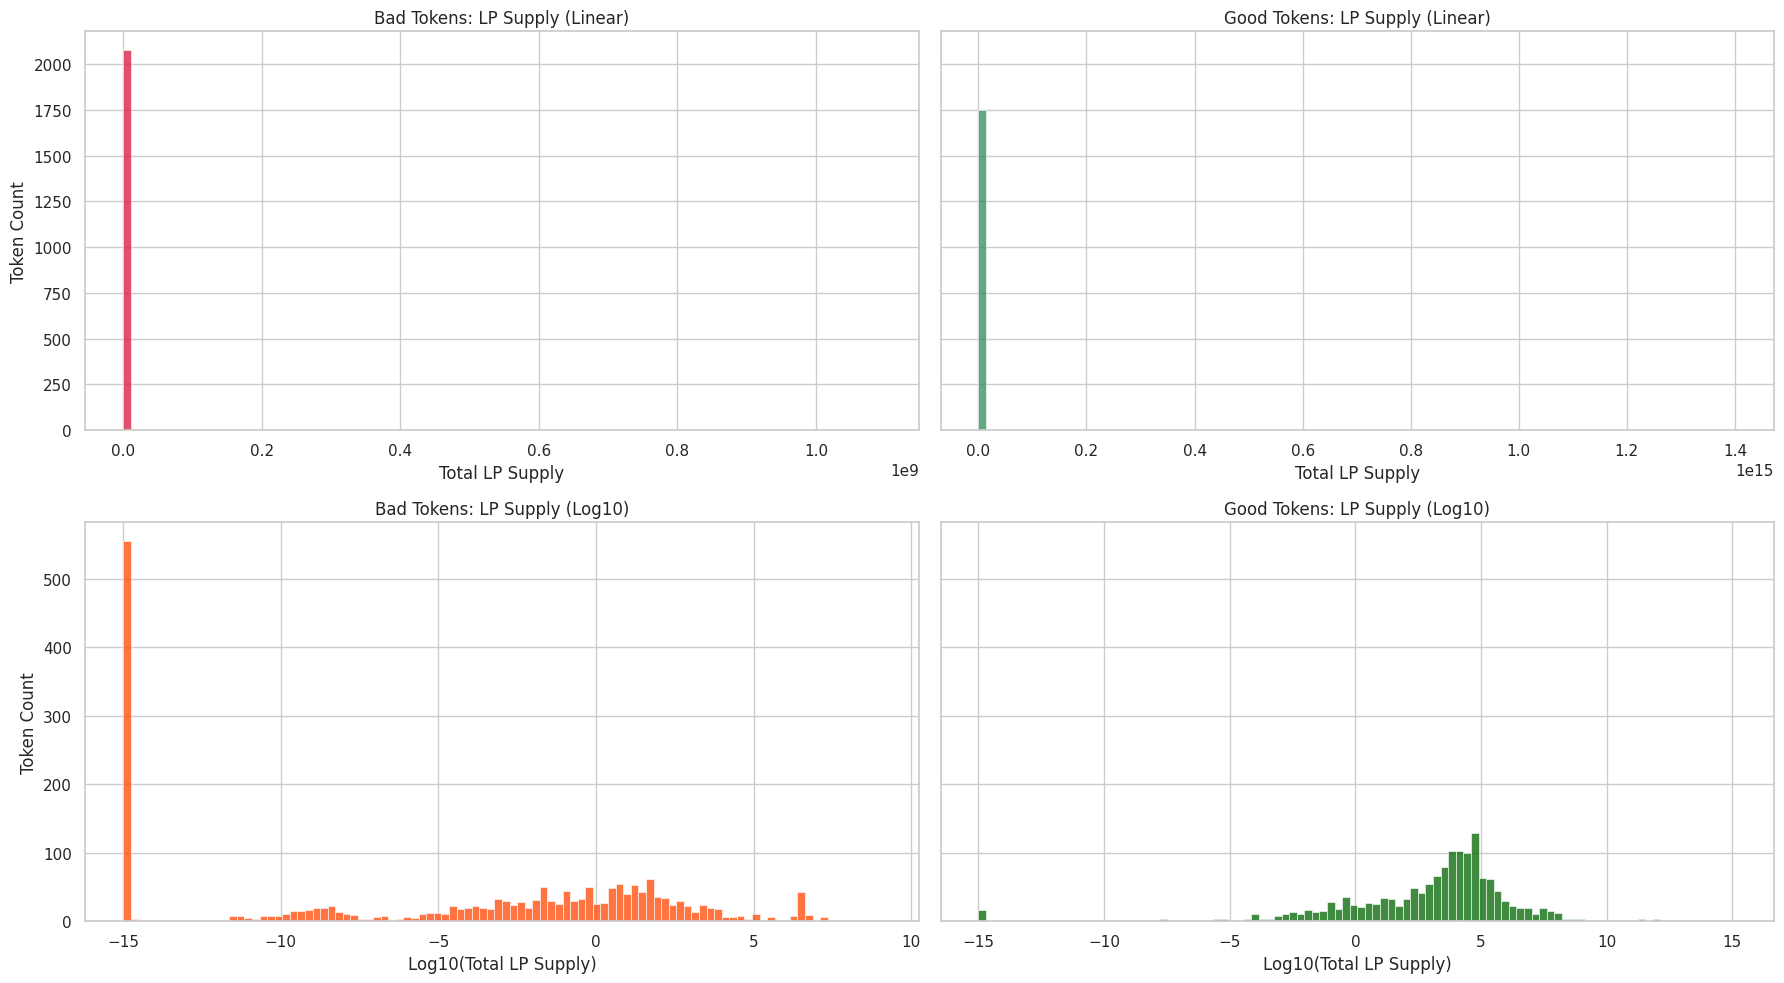

In [ ]:
# Load data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Clean and convert LP supply values
def clean_lp_supply(df):
    df = df.copy()
    df = df[pd.to_numeric(df['total_lp_supply'], errors='coerce').notnull()]
    df['total_lp_supply'] = df['total_lp_supply'].astype(float)
    return df

df_bad_clean = clean_lp_supply(df_liquidity_bad)
df_good_clean = clean_lp_supply(df_liquidity_good)

# Prepare log values (avoid log(0) or negative)
log_lp_bad = np.log10(df_bad_clean[df_bad_clean['total_lp_supply'] > 0]['total_lp_supply'])
log_lp_good = np.log10(df_good_clean[df_good_clean['total_lp_supply'] > 0]['total_lp_supply'])

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Create subplots: 2 rows (linear & log), 2 cols (bad & good)
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey='row')

# ==== LINEAR SCALE ====
# Bad
sns.histplot(df_bad_clean['total_lp_supply'], bins=100, kde=False, color='crimson', ax=axes[0][0])
axes[0][0].set_title("Bad Tokens: LP Supply (Linear)")
axes[0][0].set_xlabel("Total LP Supply")
axes[0][0].set_ylabel("Token Count")
axes[0][0].grid(True)

# Good
sns.histplot(df_good_clean['total_lp_supply'], bins=100, kde=False, color='seagreen', ax=axes[0][1])
axes[0][1].set_title("Good Tokens: LP Supply (Linear)")
axes[0][1].set_xlabel("Total LP Supply")
axes[0][1].set_ylabel("")
axes[0][1].grid(True)

# ==== LOG SCALE ====
# Bad
sns.histplot(log_lp_bad, bins=100, kde=False, color='orangered', ax=axes[1][0])
axes[1][0].set_title("Bad Tokens: LP Supply (Log10)")
axes[1][0].set_xlabel("Log10(Total LP Supply)")
axes[1][0].set_ylabel("Token Count")
axes[1][0].grid(True)

# Good
sns.histplot(log_lp_good, bins=100, kde=False, color='darkgreen', ax=axes[1][1])
axes[1][1].set_title("Good Tokens: LP Supply (Log10)")
axes[1][1].set_xlabel("Log10(Total LP Supply)")
axes[1][1].set_ylabel("")
axes[1][1].grid(True)

# Final layout
plt.tight_layout()
plt.show()

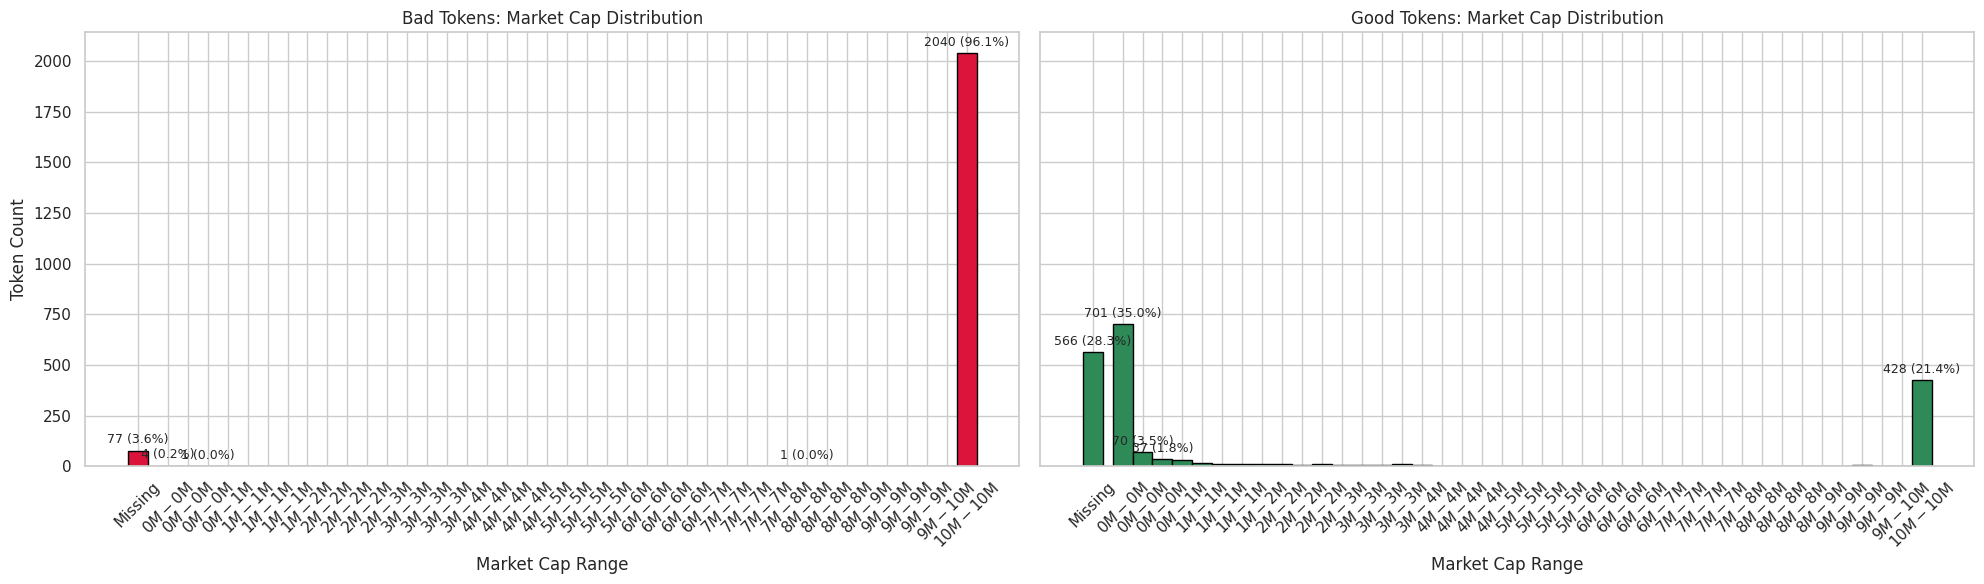

In [ ]:
# Load data
df_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Shared bin settings
bin_edges = np.arange(0, 1.05e7, 2.5e5)  # $0 to $10M in $250K steps
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_centers_with_missing = np.insert(bin_centers, 0, -2.5e5)
labels = ['Missing'] + [f"${int(bin_edges[i]/1e6):,}M-${int(bin_edges[i+1]/1e6):,}M" for i in range(len(bin_edges)-1)]

def prepare_market_cap_distribution(df):
    df = df.copy()
    df['market_cap_usd_cleaned'] = pd.to_numeric(df['market_cap_usd'], errors='coerce')
    data = df['market_cap_usd_cleaned'].dropna()
    data_clipped = data.clip(upper=1e7)
    counts, _ = np.histogram(data_clipped, bins=bin_edges)
    counts = np.insert(counts, 0, df['market_cap_usd_cleaned'].isna().sum())  # Add missing
    return counts

# Get counts
counts_bad = prepare_market_cap_distribution(df_bad)
counts_good = prepare_market_cap_distribution(df_good)
total_bad = counts_bad.sum()
total_good = counts_good.sum()

# Identify top 5 bins for each
top_5_bad = np.argsort(counts_bad)[-5:]
top_5_good = np.argsort(counts_good)[-5:]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# --- BAD TOKENS ---
bars_bad = axes[0].bar(bin_centers_with_missing, counts_bad, width=2.5e5, color='crimson', edgecolor='black')
axes[0].set_title("Bad Tokens: Market Cap Distribution")
axes[0].set_xlabel("Market Cap Range")
axes[0].set_ylabel("Token Count")
axes[0].set_xticks(bin_centers_with_missing)
axes[0].set_xticklabels(labels, rotation=45)

# Annotate top 5
for i, bar in enumerate(bars_bad):
    if i in top_5_bad and counts_bad[i] > 0:
        pct = (counts_bad[i] / total_bad) * 100
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total_bad * 0.01,
                     f'{counts_bad[i]} ({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

# --- GOOD TOKENS ---
bars_good = axes[1].bar(bin_centers_with_missing, counts_good, width=2.5e5, color='seagreen', edgecolor='black')
axes[1].set_title("Good Tokens: Market Cap Distribution")
axes[1].set_xlabel("Market Cap Range")
axes[1].set_xticks(bin_centers_with_missing)
axes[1].set_xticklabels(labels, rotation=45)

# Annotate top 5
for i, bar in enumerate(bars_good):
    if i in top_5_good and counts_good[i] > 0:
        pct = (counts_good[i] / total_good) * 100
        axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total_good * 0.01,
                     f'{counts_good[i]} ({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

# Layout
plt.tight_layout()
plt.show()


## Market cap and liquidity pool depth

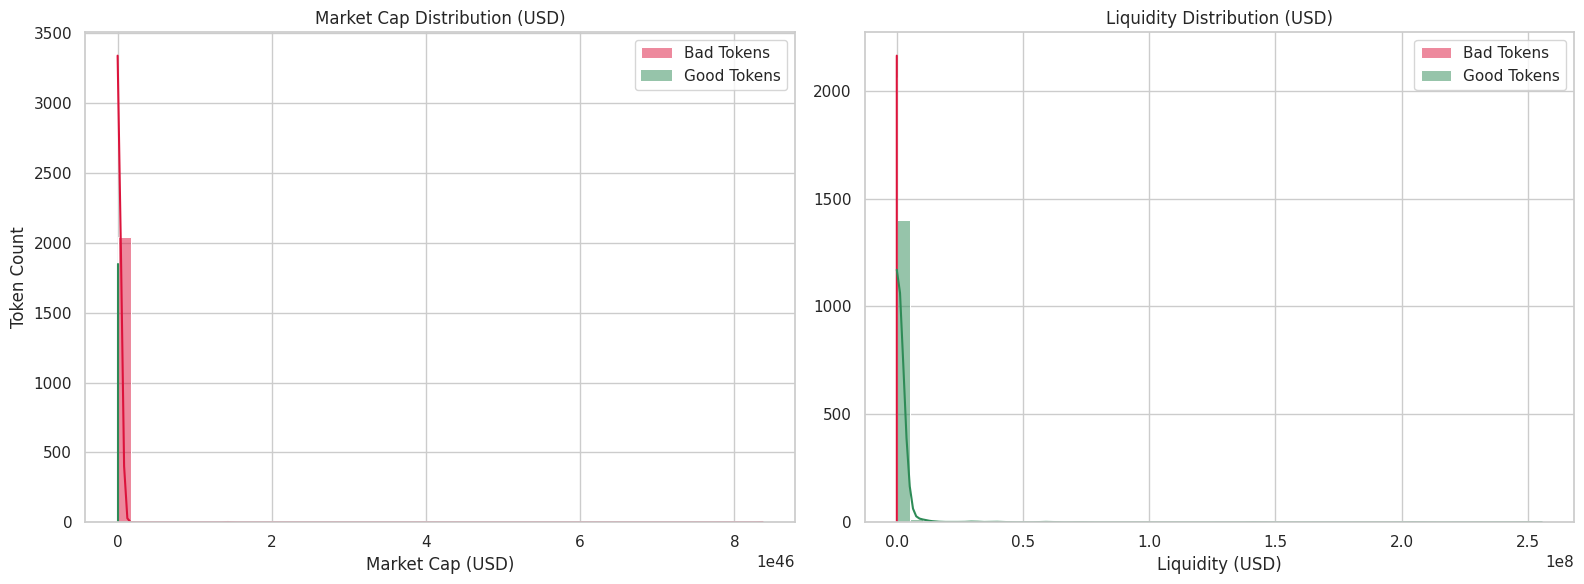

In [ ]:
# Load the correct data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Clean and convert numeric columns
for df in [df_liquidity_bad, df_liquidity_good]:
    df['market_cap_usd'] = pd.to_numeric(df['market_cap_usd'], errors='coerce')
    df['liquidity_usd'] = pd.to_numeric(df['liquidity_usd'], errors='coerce')

# Set theme
sns.set_theme(style="whitegrid")

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Market Cap plot
sns.histplot(df_liquidity_bad['market_cap_usd'].dropna(), bins=50, color='crimson', label='Bad Tokens', ax=axes[0], kde=True)
sns.histplot(df_liquidity_good['market_cap_usd'].dropna(), bins=50, color='seagreen', label='Good Tokens', ax=axes[0], kde=True)
axes[0].set_title('Market Cap Distribution (USD)')
axes[0].set_xlabel('Market Cap (USD)')
axes[0].set_ylabel('Token Count')
axes[0].legend()

# Liquidity plot
sns.histplot(df_liquidity_bad['liquidity_usd'].dropna(), bins=50, color='crimson', label='Bad Tokens', ax=axes[1], kde=True)
sns.histplot(df_liquidity_good['liquidity_usd'].dropna(), bins=50, color='seagreen', label='Good Tokens', ax=axes[1], kde=True)
axes[1].set_title('Liquidity Distribution (USD)')
axes[1].set_xlabel('Liquidity (USD)')
axes[1].set_ylabel('')
axes[1].legend()

# Final layout
plt.tight_layout()
plt.show()


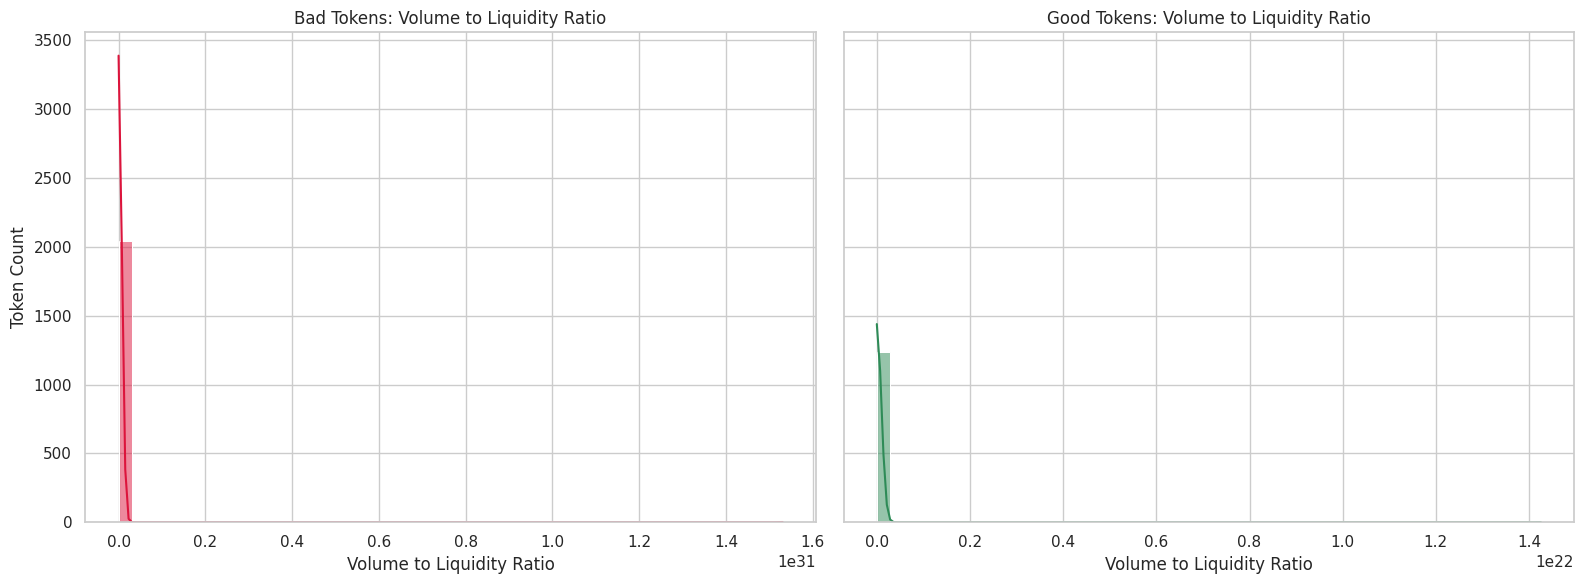

In [ ]:
# Load data (if not already loaded)
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Convert column to numeric (in case of string issues)
for df in [df_liquidity_bad, df_liquidity_good]:
    df['volume_to_liquidity_ratio'] = pd.to_numeric(df['volume_to_liquidity_ratio'], errors='coerce')

# Set theme
sns.set_theme(style="whitegrid")

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Bad tokens
sns.histplot(df_liquidity_bad['volume_to_liquidity_ratio'].dropna(), bins=50, kde=True, color='crimson', ax=axes[0])
axes[0].set_title('Bad Tokens: Volume to Liquidity Ratio')
axes[0].set_xlabel('Volume to Liquidity Ratio')
axes[0].set_ylabel('Token Count')

# Good tokens
sns.histplot(df_liquidity_good['volume_to_liquidity_ratio'].dropna(), bins=50, kde=True, color='seagreen', ax=axes[1])
axes[1].set_title('Good Tokens: Volume to Liquidity Ratio')
axes[1].set_xlabel('Volume to Liquidity Ratio')
axes[1].set_ylabel('')

# Final layout
plt.tight_layout()
plt.show()


## At least 95% of largest pool's liquidity token burned/locked for 15 days or longer

/tmp/ipykernel_9097/3645798562.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=locked_counts_bad.index.astype(str), y=locked_counts_bad.values, palette='Reds', ax=axes[0])
/tmp/ipykernel_9097/3645798562.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=locked_counts_good.index.astype(str), y=locked_counts_good.values, palette='Greens', ax=axes[1])


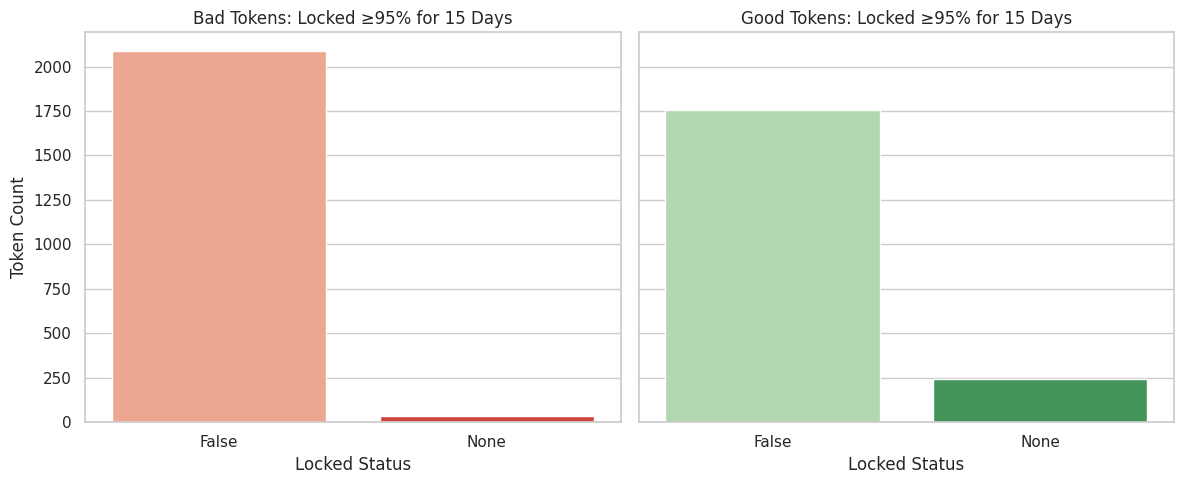

In [ ]:
# Load your data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Function to robustly clean boolean column
def clean_locked_column(df):
    df = df.copy()
    
    def to_bool(val):
        val = str(val).strip().lower()
        if val in ['true', '1', 'yes']:
            return True
        elif val in ['false', '0', 'no']:
            return False
        else:
            return None

    df['locked_clean'] = df['locked_95_for_15_days'].apply(to_bool)
    return df

# Clean both datasets
df_bad_clean = clean_locked_column(df_liquidity_bad)
df_good_clean = clean_locked_column(df_liquidity_good)

# Count values
locked_counts_bad = df_bad_clean['locked_clean'].value_counts(dropna=False).sort_index()
locked_counts_good = df_good_clean['locked_clean'].value_counts(dropna=False).sort_index()

# Set up side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.set_theme(style="whitegrid")

# BAD tokens
sns.barplot(x=locked_counts_bad.index.astype(str), y=locked_counts_bad.values, palette='Reds', ax=axes[0])
axes[0].set_title('Bad Tokens: Locked ≥95% for 15 Days')
axes[0].set_xlabel('Locked Status')
axes[0].set_ylabel('Token Count')

# GOOD tokens
sns.barplot(x=locked_counts_good.index.astype(str), y=locked_counts_good.values, palette='Greens', ax=axes[1])
axes[1].set_title('Good Tokens: Locked ≥95% for 15 Days')
axes[1].set_xlabel('Locked Status')
axes[1].set_ylabel('')

# Final layout
plt.tight_layout()
plt.show()


## Owner/creator wallet contains less than 5% of liquidity

/tmp/ipykernel_9097/4016747859.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=creator_counts_bad.index.astype(str), y=creator_counts_bad.values, palette='Reds', ax=axes[0])
/tmp/ipykernel_9097/4016747859.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=creator_counts_good.index.astype(str), y=creator_counts_good.values, palette='Greens', ax=axes[1])


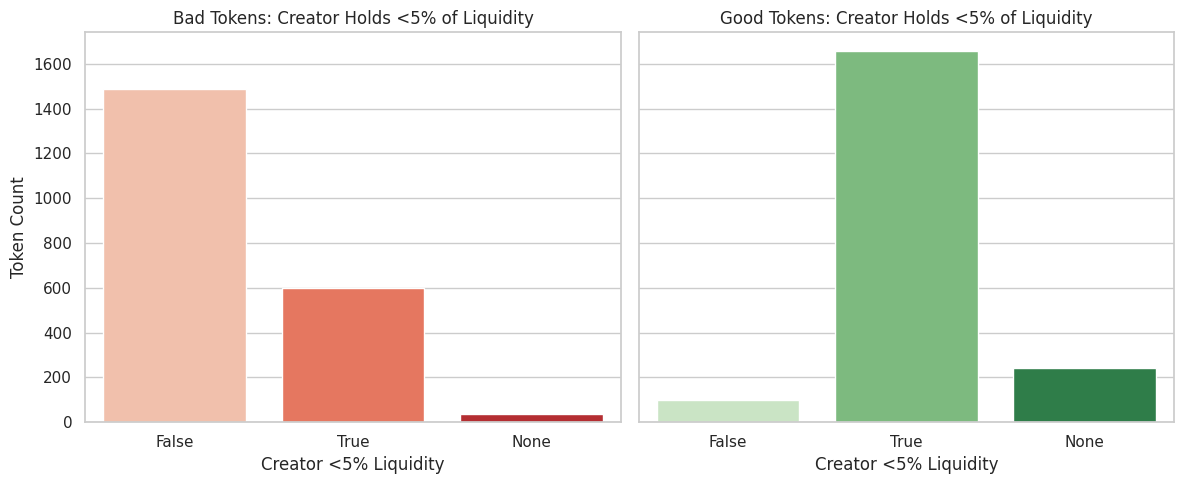

In [ ]:
# Load data (if not already loaded)
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Function to robustly clean 'creator_under_5_percent' column
def clean_creator_hold_column(df):
    df = df.copy()
    
    def to_bool(val):
        val = str(val).strip().lower()
        if val in ['true', '1', 'yes']:
            return True
        elif val in ['false', '0', 'no']:
            return False
        else:
            return None

    df['creator_under_5_clean'] = df['creator_under_5_percent'].apply(to_bool)
    return df

# Apply cleaning
df_bad_clean = clean_creator_hold_column(df_liquidity_bad)
df_good_clean = clean_creator_hold_column(df_liquidity_good)

# Count values
creator_counts_bad = df_bad_clean['creator_under_5_clean'].value_counts(dropna=False).sort_index()
creator_counts_good = df_good_clean['creator_under_5_clean'].value_counts(dropna=False).sort_index()

# Set up side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.set_theme(style="whitegrid")

# BAD tokens
sns.barplot(x=creator_counts_bad.index.astype(str), y=creator_counts_bad.values, palette='Reds', ax=axes[0])
axes[0].set_title('Bad Tokens: Creator Holds <5% of Liquidity')
axes[0].set_xlabel('Creator <5% Liquidity')
axes[0].set_ylabel('Token Count')

# GOOD tokens
sns.barplot(x=creator_counts_good.index.astype(str), y=creator_counts_good.values, palette='Greens', ax=axes[1])
axes[1].set_title('Good Tokens: Creator Holds <5% of Liquidity')
axes[1].set_xlabel('Creator <5% Liquidity')
axes[1].set_ylabel('')

# Final layout
plt.tight_layout()
plt.show()


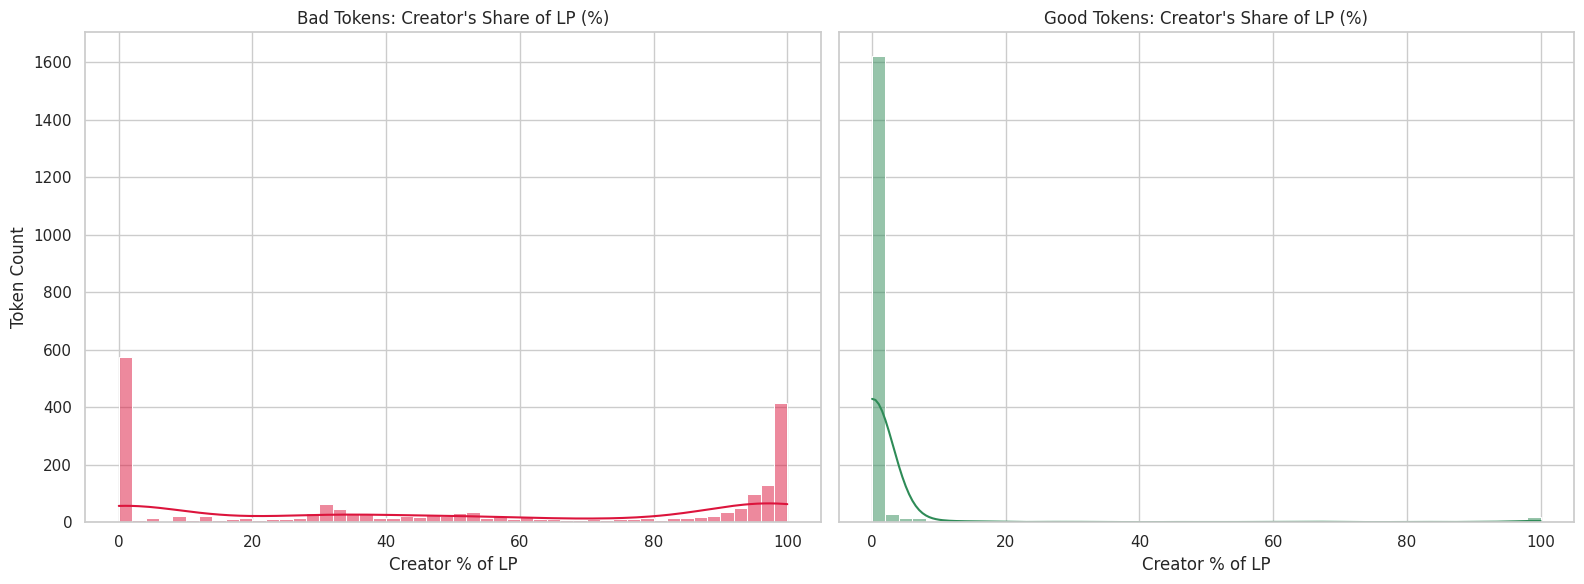

In [ ]:
# Load data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Function to clean and clip creator percent of LP
def clean_creator_lp_percent(df):
    df = df.copy()
    df['creator_percent_of_lp_cleaned'] = pd.to_numeric(df['creator_percent_of_lp'], errors='coerce').clip(0, 100)
    return df

# Apply cleaning
df_bad_clean = clean_creator_lp_percent(df_liquidity_bad)
df_good_clean = clean_creator_lp_percent(df_liquidity_good)

# Set seaborn style
sns.set_theme(style="whitegrid")

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for Bad Tokens
sns.histplot(df_bad_clean['creator_percent_of_lp_cleaned'].dropna(), bins=50, kde=True, color='crimson', ax=axes[0])
axes[0].set_title("Bad Tokens: Creator's Share of LP (%)")
axes[0].set_xlabel("Creator % of LP")
axes[0].set_ylabel("Token Count")

# Plot for Good Tokens
sns.histplot(df_good_clean['creator_percent_of_lp_cleaned'].dropna(), bins=50, kde=True, color='seagreen', ax=axes[1])
axes[1].set_title("Good Tokens: Creator's Share of LP (%)")
axes[1].set_xlabel("Creator % of LP")
axes[1].set_ylabel("")

# Final layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_9097/795516137.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=owner_counts_bad.index.astype(str), y=owner_counts_bad.values, palette='Reds', ax=axes[0])
/tmp/ipykernel_9097/795516137.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=owner_counts_good.index.astype(str), y=owner_counts_good.values, palette='Greens', ax=axes[1])


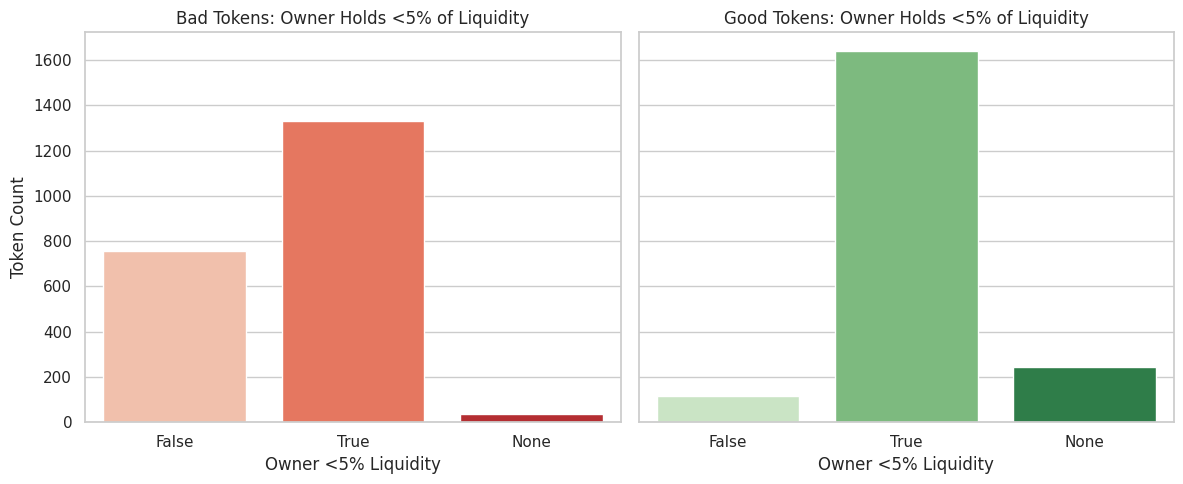

In [ ]:
# Load data (if not already loaded)
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Function to clean and convert the column to boolean
def clean_owner_under_5_column(df):
    df = df.copy()
    
    def to_bool(val):
        val = str(val).strip().lower()
        if val in ['true', '1', 'yes']:
            return True
        elif val in ['false', '0', 'no']:
            return False
        else:
            return None

    df['owner_under_5_cleaned'] = df['owner_under_5_percent'].apply(to_bool)
    return df

# Clean both datasets
df_bad_clean = clean_owner_under_5_column(df_liquidity_bad)
df_good_clean = clean_owner_under_5_column(df_liquidity_good)

# Count values
owner_counts_bad = df_bad_clean['owner_under_5_cleaned'].value_counts(dropna=False).sort_index()
owner_counts_good = df_good_clean['owner_under_5_cleaned'].value_counts(dropna=False).sort_index()

# Set up side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.set_theme(style="whitegrid")

# BAD tokens
sns.barplot(x=owner_counts_bad.index.astype(str), y=owner_counts_bad.values, palette='Reds', ax=axes[0])
axes[0].set_title('Bad Tokens: Owner Holds <5% of Liquidity')
axes[0].set_xlabel('Owner <5% Liquidity')
axes[0].set_ylabel('Token Count')

# GOOD tokens
sns.barplot(x=owner_counts_good.index.astype(str), y=owner_counts_good.values, palette='Greens', ax=axes[1])
axes[1].set_title('Good Tokens: Owner Holds <5% of Liquidity')
axes[1].set_xlabel('Owner <5% Liquidity')
axes[1].set_ylabel('')

# Final layout
plt.tight_layout()
plt.show()


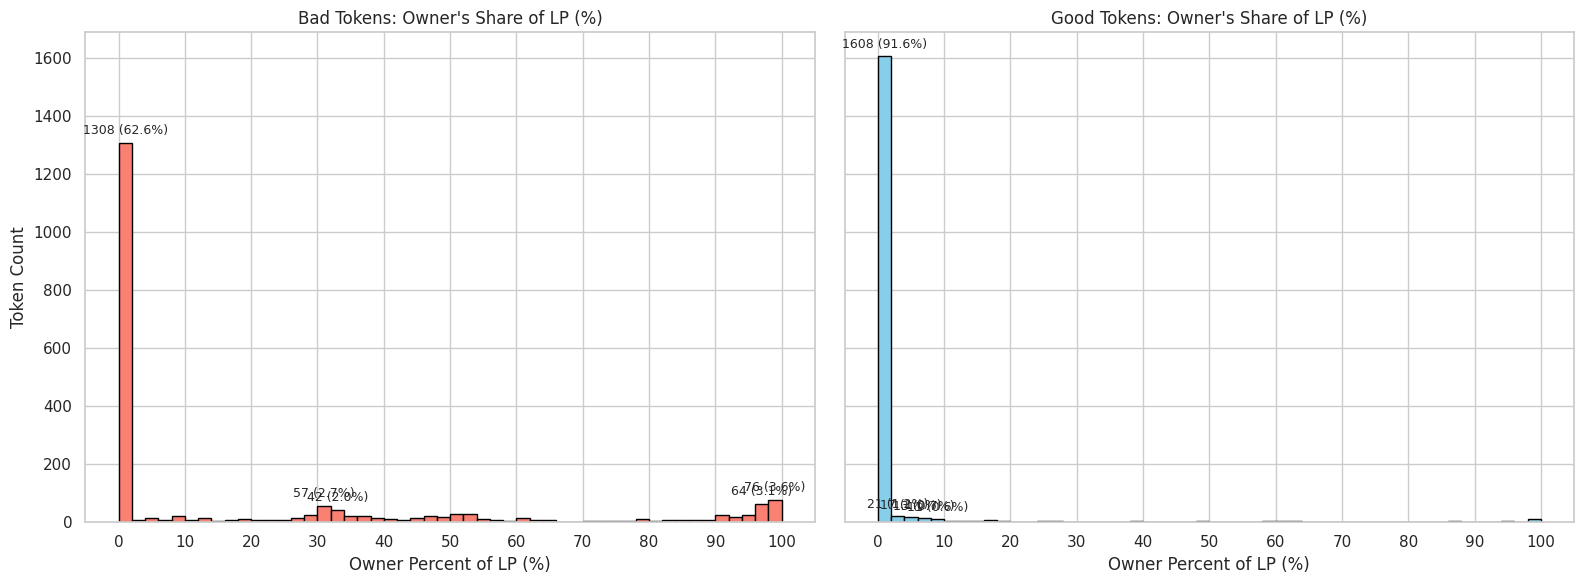

In [ ]:
# Load the datasets (if not already loaded)
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

def prepare_hist_data(df, col_name='owner_percent_of_lp'):
    # Ensure data is numeric and clipped to [0, 100]
    data_clipped = pd.to_numeric(df[col_name], errors='coerce').clip(0, 100).dropna()

    # Histogram bins and counts
    bin_edges = np.linspace(0, 100, 51)  # 50 bins from 0 to 100
    counts, edges = np.histogram(data_clipped, bins=bin_edges)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    total = counts.sum()

    # Identify top 5 bins by count (or fewer if less data)
    top_5_indices = np.argsort(counts)[-5:]

    return bin_centers, counts, total, top_5_indices

# Prepare data for both datasets
bin_centers_bad, counts_bad, total_bad, top5_bad = prepare_hist_data(df_liquidity_bad)
bin_centers_good, counts_good, total_good, top5_good = prepare_hist_data(df_liquidity_good)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Bad tokens histogram
bars_bad = axes[0].bar(bin_centers_bad, counts_bad, width=2, color='salmon', edgecolor='black')
axes[0].set_title("Bad Tokens: Owner's Share of LP (%)")
axes[0].set_xlabel('Owner Percent of LP (%)')
axes[0].set_ylabel('Token Count')
axes[0].set_xticks(np.arange(0, 110, 10))

# Annotate top 5 bars
for i, bar in enumerate(bars_bad):
    if i in top5_bad and counts_bad[i] > 0:
        percentage = (counts_bad[i] / total_bad) * 100
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total_bad * 0.01,
                     f'{counts_bad[i]} ({percentage:.1f}%)',
                     ha='center', va='bottom', fontsize=9)

# Good tokens histogram
bars_good = axes[1].bar(bin_centers_good, counts_good, width=2, color='skyblue', edgecolor='black')
axes[1].set_title("Good Tokens: Owner's Share of LP (%)")
axes[1].set_xlabel('Owner Percent of LP (%)')
axes[1].set_ylabel('')
axes[1].set_xticks(np.arange(0, 110, 10))

# Annotate top 5 bars
for i, bar in enumerate(bars_good):
    if i in top5_good and counts_good[i] > 0:
        percentage = (counts_good[i] / total_good) * 100
        axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total_good * 0.01,
                     f'{counts_good[i]} ({percentage:.1f}%)',
                     ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Locked liquidity % distribution

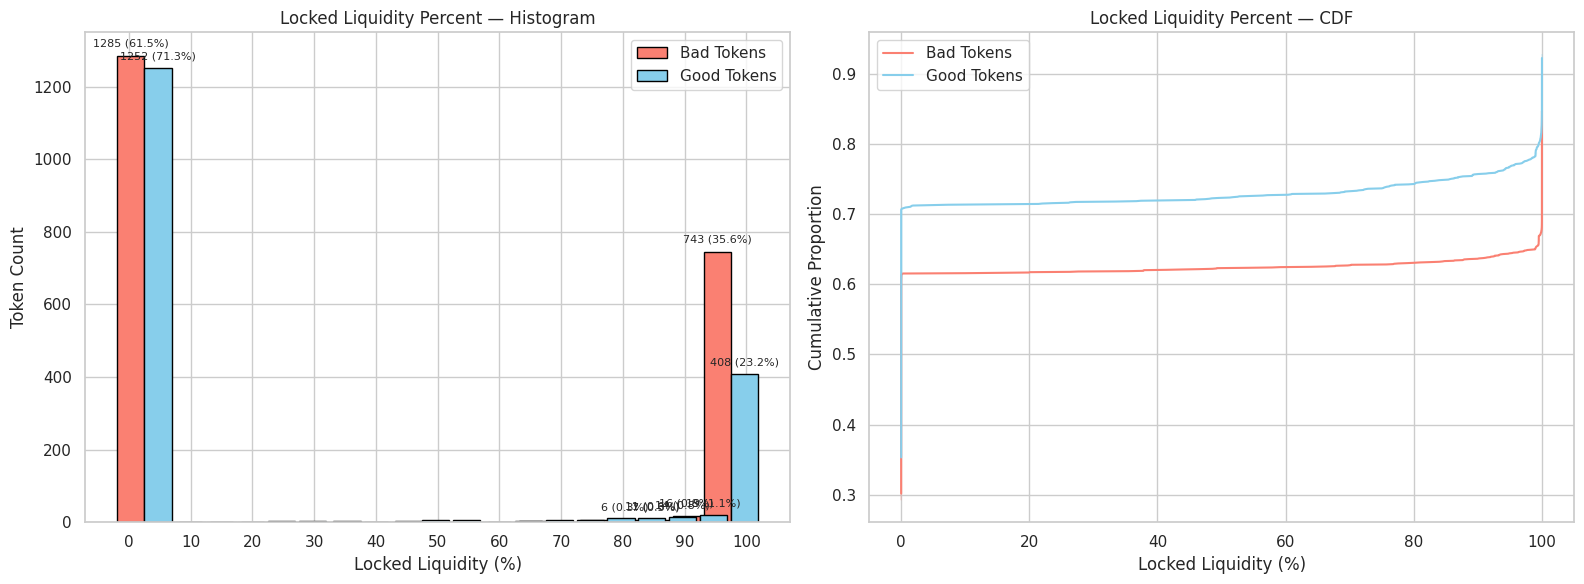

In [ ]:
# Load your data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

def prepare_locked_liquidity_hist(df, col='locked_liquidity_percent'):
    cleaned = pd.to_numeric(df[col], errors='coerce').clip(0, 100).dropna()
    bin_edges = np.linspace(0, 100, 21)  # 20 bins of 5%
    counts, _ = np.histogram(cleaned, bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    total = counts.sum()
    top_indices = np.argsort(counts)[-5:]  # Top 5 bins by count
    return bin_centers, counts, total, cleaned, top_indices

def compute_cdf(data):
    sorted_vals = np.sort(data)
    cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    return sorted_vals, cdf

# Prepare data
centers_bad, counts_bad, total_bad, cleaned_bad, top_bad = prepare_locked_liquidity_hist(df_liquidity_bad)
centers_good, counts_good, total_good, cleaned_good, top_good = prepare_locked_liquidity_hist(df_liquidity_good)
x_cdf_bad, y_cdf_bad = compute_cdf(cleaned_bad)
x_cdf_good, y_cdf_good = compute_cdf(cleaned_good)

# Plot: Histogram + CDF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Histogram with side-by-side bars ---
bar_width = 2.2
offset = bar_width

bars_bad = axes[0].bar(centers_bad - offset, counts_bad, width=bar_width*2, 
                       label='Bad Tokens', color='salmon', edgecolor='black')

bars_good = axes[0].bar(centers_good + offset, counts_good, width=bar_width*2, 
                        label='Good Tokens', color='skyblue', edgecolor='black')

axes[0].set_title('Locked Liquidity Percent — Histogram')
axes[0].set_xlabel('Locked Liquidity (%)')
axes[0].set_ylabel('Token Count')
axes[0].set_xticks(np.arange(0, 110, 10))
axes[0].legend()

# Annotate top 5 bins (bad)
for i in top_bad:
    if counts_bad[i] > 0:
        pct = (counts_bad[i] / total_bad) * 100
        axes[0].text(centers_bad[i] - offset, counts_bad[i] + total_bad * 0.01,
                     f'{counts_bad[i]} ({pct:.1f}%)', ha='center', va='bottom', fontsize=8)

# Annotate top 5 bins (good)
for i in top_good:
    if counts_good[i] > 0:
        pct = (counts_good[i] / total_good) * 100
        axes[0].text(centers_good[i] + offset, counts_good[i] + total_good * 0.01,
                     f'{counts_good[i]} ({pct:.1f}%)', ha='center', va='bottom', fontsize=8)

# --- CDF Plot ---
sns.lineplot(x=x_cdf_bad, y=y_cdf_bad, ax=axes[1], label='Bad Tokens', color='salmon')
sns.lineplot(x=x_cdf_good, y=y_cdf_good, ax=axes[1], label='Good Tokens', color='skyblue')

axes[1].set_title('Locked Liquidity Percent — CDF')
axes[1].set_xlabel('Locked Liquidity (%)')
axes[1].set_ylabel('Cumulative Proportion')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


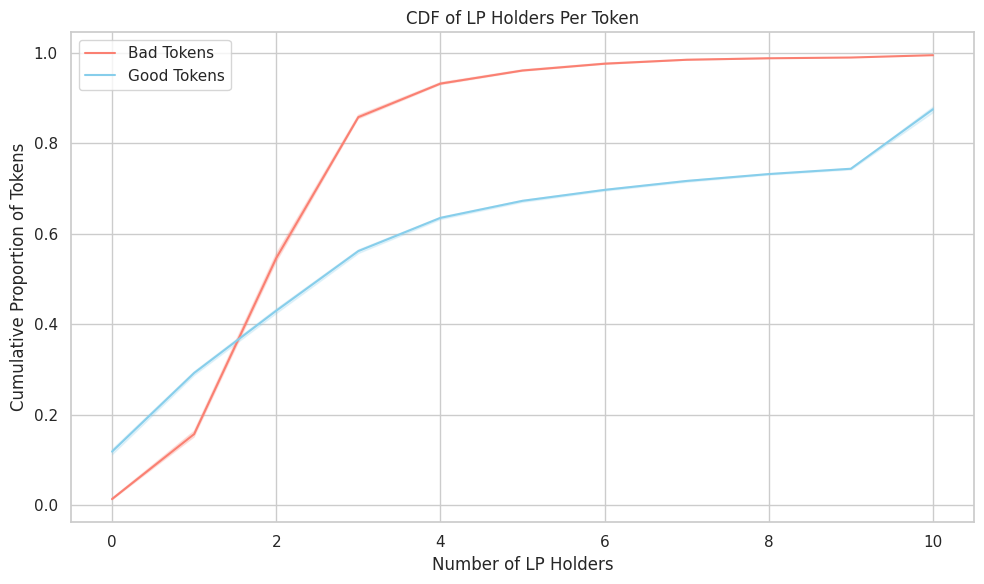

In [ ]:
# Load the datasets
df_lp_holders_bad = pd.read_csv("../csv_outputs/bad_tokens/master_lp_holders.csv")
df_lp_holders_good = pd.read_csv("../csv_outputs/good_tokens/master_lp_holders.csv")

# Compute unique LP holders per token
def compute_holders_count(df):
    return df.groupby('token_address')['address'].nunique()

holders_bad = compute_holders_count(df_lp_holders_bad)
holders_good = compute_holders_count(df_lp_holders_good)

# Sort the values to build the CDF
sorted_bad = holders_bad.sort_values()
sorted_good = holders_good.sort_values()

# Compute cumulative percentages
cdf_bad = sorted_bad.rank(method='first', pct=True)
cdf_good = sorted_good.rank(method='first', pct=True)

# Plot CDFs
plt.figure(figsize=(10, 6))
sns.lineplot(x=sorted_bad.values, y=cdf_bad.values, label='Bad Tokens', color='salmon')
sns.lineplot(x=sorted_good.values, y=cdf_good.values, label='Good Tokens', color='skyblue')

plt.title('CDF of LP Holders Per Token')
plt.xlabel('Number of LP Holders')
plt.ylabel('Cumulative Proportion of Tokens')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


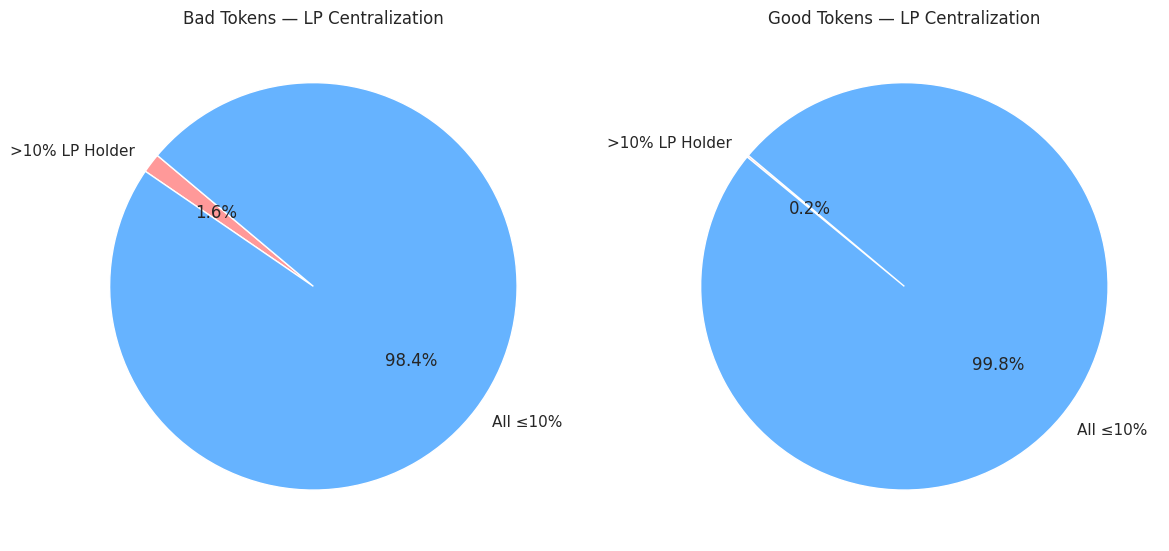

In [ ]:
# Load the data
df_lp_holders_bad = pd.read_csv("../csv_outputs/bad_tokens/master_lp_holders.csv")
df_lp_holders_good = pd.read_csv("../csv_outputs/good_tokens/master_lp_holders.csv")

def get_lp_ownership_distribution(df):
    # Filter tokens where any LP holder owns more than 10%
    tokens_with_large_lp = df[df['percent'] > 10]['token_address'].nunique()
    total_tokens = df['token_address'].nunique()
    return tokens_with_large_lp, total_tokens - tokens_with_large_lp

# Get data
bad_top, bad_rest = get_lp_ownership_distribution(df_lp_holders_bad)
good_top, good_rest = get_lp_ownership_distribution(df_lp_holders_good)

# Pie chart data
labels = ['>10% LP Holder', 'All ≤10%']
colors = ['#ff9999','#66b3ff']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bad tokens pie
axes[0].pie([bad_top, bad_rest], labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
axes[0].set_title('Bad Tokens — LP Centralization')

# Good tokens pie
axes[1].pie([good_top, good_rest], labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
axes[1].set_title('Good Tokens — LP Centralization')

plt.tight_layout()
plt.show()



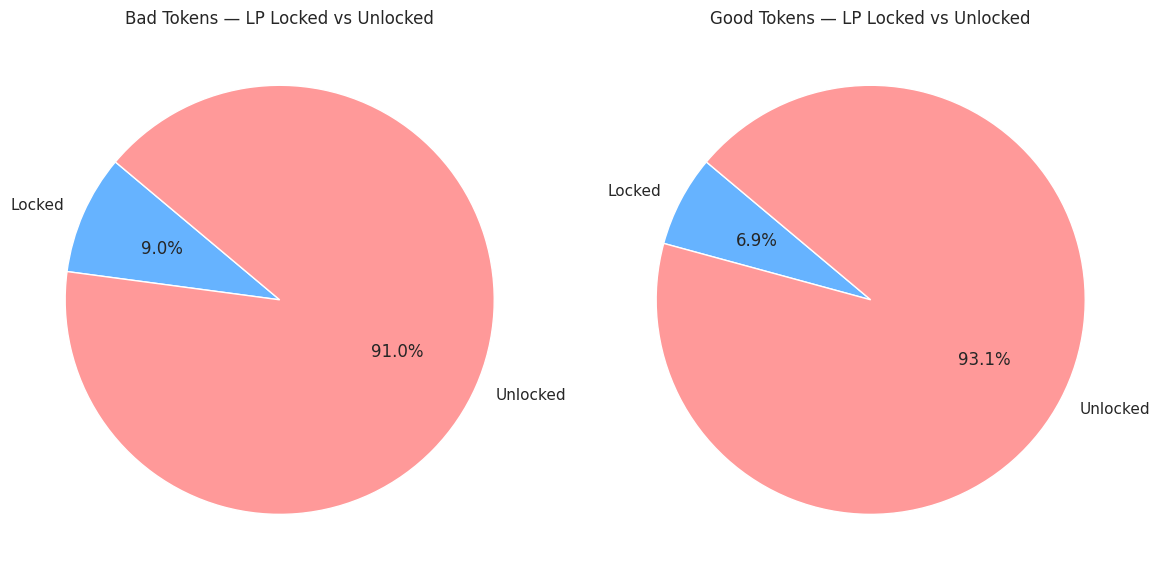

In [ ]:
# Load data
df_lp_holders_bad = pd.read_csv("../csv_outputs/bad_tokens/master_lp_holders.csv")
df_lp_holders_good = pd.read_csv("../csv_outputs/good_tokens/master_lp_holders.csv")

def prepare_lp_lock_distribution(df):
    # Clean numeric fields
    df['percent'] = pd.to_numeric(df['percent'], errors='coerce')
    df['balance'] = pd.to_numeric(df['balance'], errors='coerce')
    df = df.dropna(subset=['percent'])

    # Filter out 0x000...000 address
    zero_address = '0x0000000000000000000000000000000000000000'
    df = df[df['address'].str.lower() != zero_address]

    # Count locked/unlocked
    lock_counts = df['is_locked'].value_counts()
    
    # Ensure both categories exist
    locked = lock_counts.get(True, 0)
    unlocked = lock_counts.get(False, 0)

    return [locked, unlocked]

# Get data
locked_counts_bad = prepare_lp_lock_distribution(df_lp_holders_bad)
locked_counts_good = prepare_lp_lock_distribution(df_lp_holders_good)

labels = ['Locked', 'Unlocked']
colors = ['#66b3ff', '#ff9999']

# Plot side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bad tokens
axes[0].pie(locked_counts_bad, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].set_title("Bad Tokens — LP Locked vs Unlocked")

# Good tokens
axes[1].pie(locked_counts_good, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
axes[1].set_title("Good Tokens — LP Locked vs Unlocked")

plt.tight_layout()
plt.show()


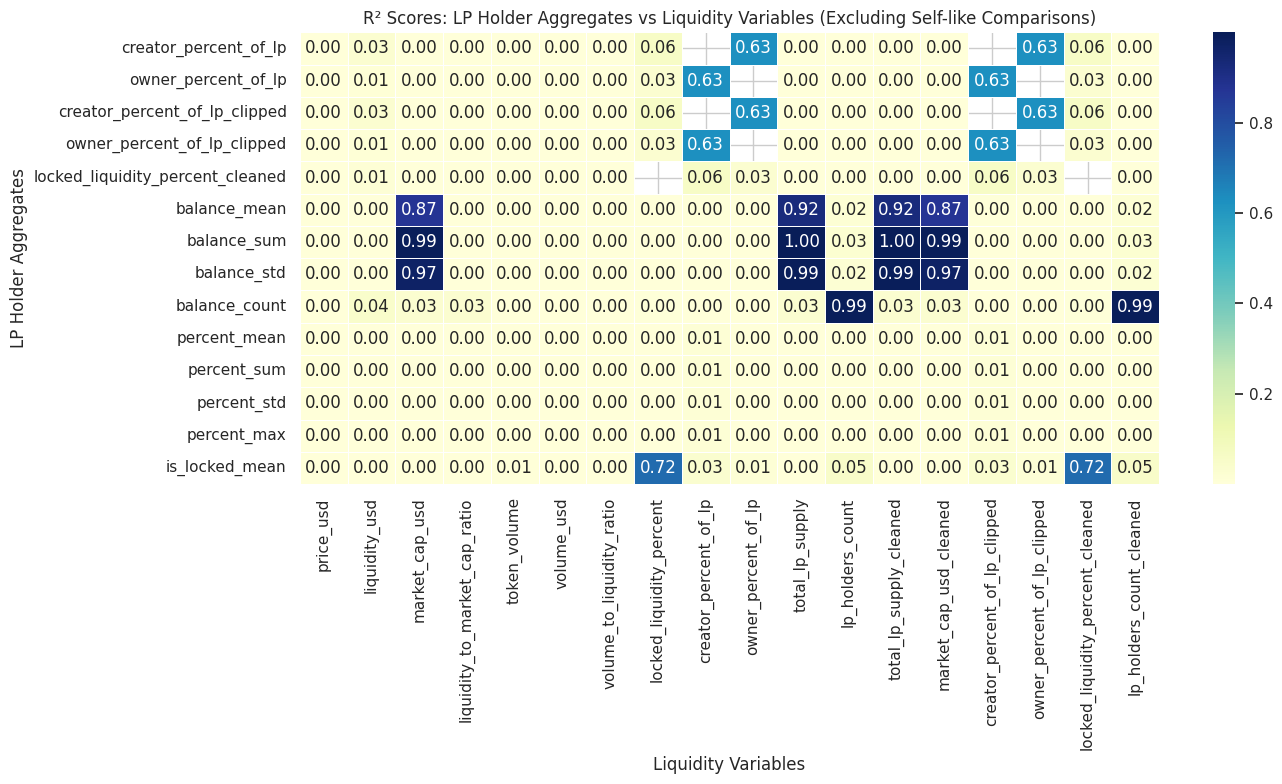

In [ ]:
import re
# Exclude zero address
df_lp_holders = df_lp_holders[df_lp_holders['address'] != '0x0000000000000000000000000000000000000000']

# Aggregate LP holders per token
agg_lp_holders = df_lp_holders.groupby('token_address').agg({
    'balance': ['mean', 'sum', 'std', 'count'],
    'percent': ['mean', 'sum', 'std', 'max'],
    'is_locked': 'mean'  # ratio of locked holders
})

# Flatten MultiIndex columns
agg_lp_holders.columns = ['_'.join(col) for col in agg_lp_holders.columns]
agg_lp_holders.reset_index(inplace=True)

# Drop categorical and boolean columns
liquidity_numeric = df_liquidity.select_dtypes(include='number').copy()

# Keep token_address for merging
liquidity_numeric['token_address'] = df_liquidity['token_address']

# Merge on token_address
merged_df = pd.merge(liquidity_numeric, agg_lp_holders, on='token_address', how='inner')

# Drop rows with NaNs (optional)
merged_df = merged_df.dropna()

# Helper to strip variable suffixes
def base_var_name(var):
    return re.sub(r'_(cleaned|clipped|mean|sum|std|max|count)$', '', var)

# Separate variable lists
lp_cols = [col for col in merged_df.columns if any(stat in col for stat in ['balance_', 'percent_', 'is_locked'])]
liq_cols = [col for col in liquidity_numeric.columns if col != 'token_address']

# Initialize R² matrix
r2_df = pd.DataFrame(index=lp_cols, columns=liq_cols)

# Compute R², skipping variables with matching base names
for y_col in lp_cols:
    for x_col in liq_cols:
        if base_var_name(x_col) == base_var_name(y_col):
            r2_df.loc[y_col, x_col] = np.nan
            continue
        X = merged_df[[x_col]]
        y = merged_df[y_col]
        if len(X) > 2:
            model = LinearRegression().fit(X, y)
            r2 = model.score(X, y)
            r2_df.loc[y_col, x_col] = r2

# Convert to float
r2_df = r2_df.astype(float)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(r2_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5, mask=r2_df.isnull())
plt.title("R² Scores: LP Holder Aggregates vs Liquidity Variables (Excluding Self-like Comparisons)")
plt.xlabel("Liquidity Variables")
plt.ylabel("LP Holder Aggregates")
plt.tight_layout()
plt.show()
